In [1]:
from pylab import *

In [2]:
from deficit_defs_2025_02_25 import *

Splikes version  0.1.4
Plasticnet version  0.1.12
macOS-15.3.1-arm64-arm-64bit
Base Image File: asdf/bbsk081604_all_scale2.asdf


In [3]:
mu_c=9
sigma_c=9
mu_r=0
sigma_r=0

base_sim_dir=f"sims-2025-02-25 mu {mu_c} sigma {sigma_c}"
if not os.path.exists(base_sim_dir):
    os.mkdir(base_sim_dir)
print(base_sim_dir)

sims-2025-02-25 mu 9 sigma 9


In [4]:
def default_post(number_of_neurons):
    post=pn.neurons.linear_neuron(number_of_neurons)
    post+=pn.neurons.process.sigmoid(0,50)
    return post

def default_bcm(pre,post,orthogonalization=True):
    c=pn.connections.BCM(pre,post,[-.01,.01],[.1,.2])
    
    if orthogonalization:
        c+=pn.connections.process.orthogonalization(10*minute)

    c.eta=2e-6
    c.tau=15*pn.minute   

    return c

## Deficit

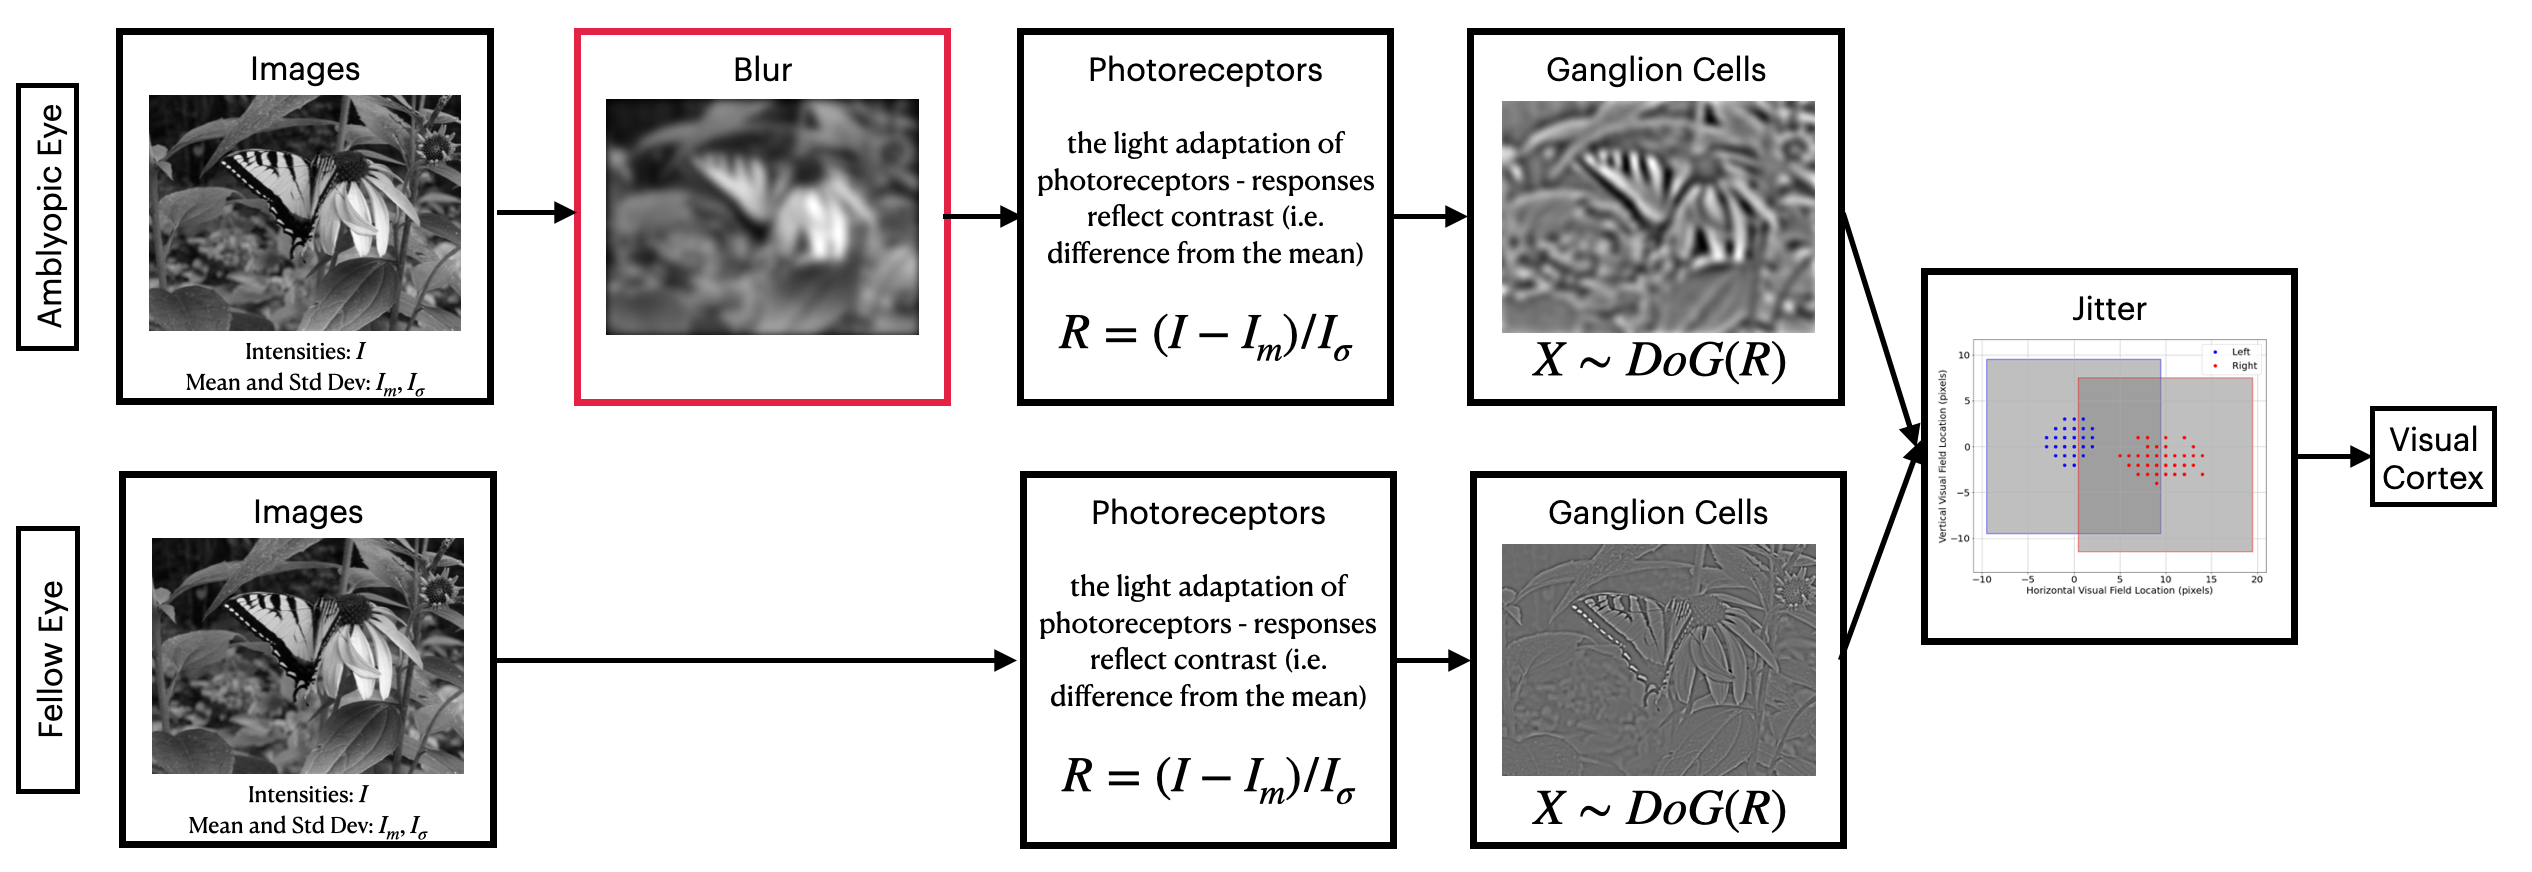

In [5]:
def deficit(blur=[2.5,-1],noise=[0.1,0.1],rf_size=19,
            eta=2e-6,
           number_of_neurons=10,
            mu_c=0,sigma_c=0,    
            mu_r=0,sigma_r=0,
           total_time=8*day,
           save_interval=1*hour):

    
    
    im=[]
    for b in blur:
        if b<0:
            im+=[pi5.filtered_images(base_image_file,
                                    {'type':'norm'},
                                    {'type':'dog','sd1':1,'sd2':3},   
                                    verbose=False,
                                    )
                ]
        else:
            im+=[pi5.filtered_images(base_image_file,
                                    {'type':'blur','size':b},
                                    {'type':'norm'},
                                    {'type':'dog','sd1':1,'sd2':3},   
                                    verbose=False,
                                    )
                ]
    pre1=pn.neurons.natural_images_with_jitter(im[0],
                                   rf_size=rf_size,
                                                sigma_r=0,
                                                sigma_c=0,
                                       verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(im[1],rf_size=rf_size,
                                other_channel=pre1,
                                    mu_r=mu_r,mu_c=mu_c,
                                    sigma_r=sigma_r,sigma_c=sigma_c,
                                verbose=False)

    pre1+=pn.neurons.process.add_noise_normal(0,noise[0])

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,noise[1])

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=200*ms

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]


## Continuous Fix

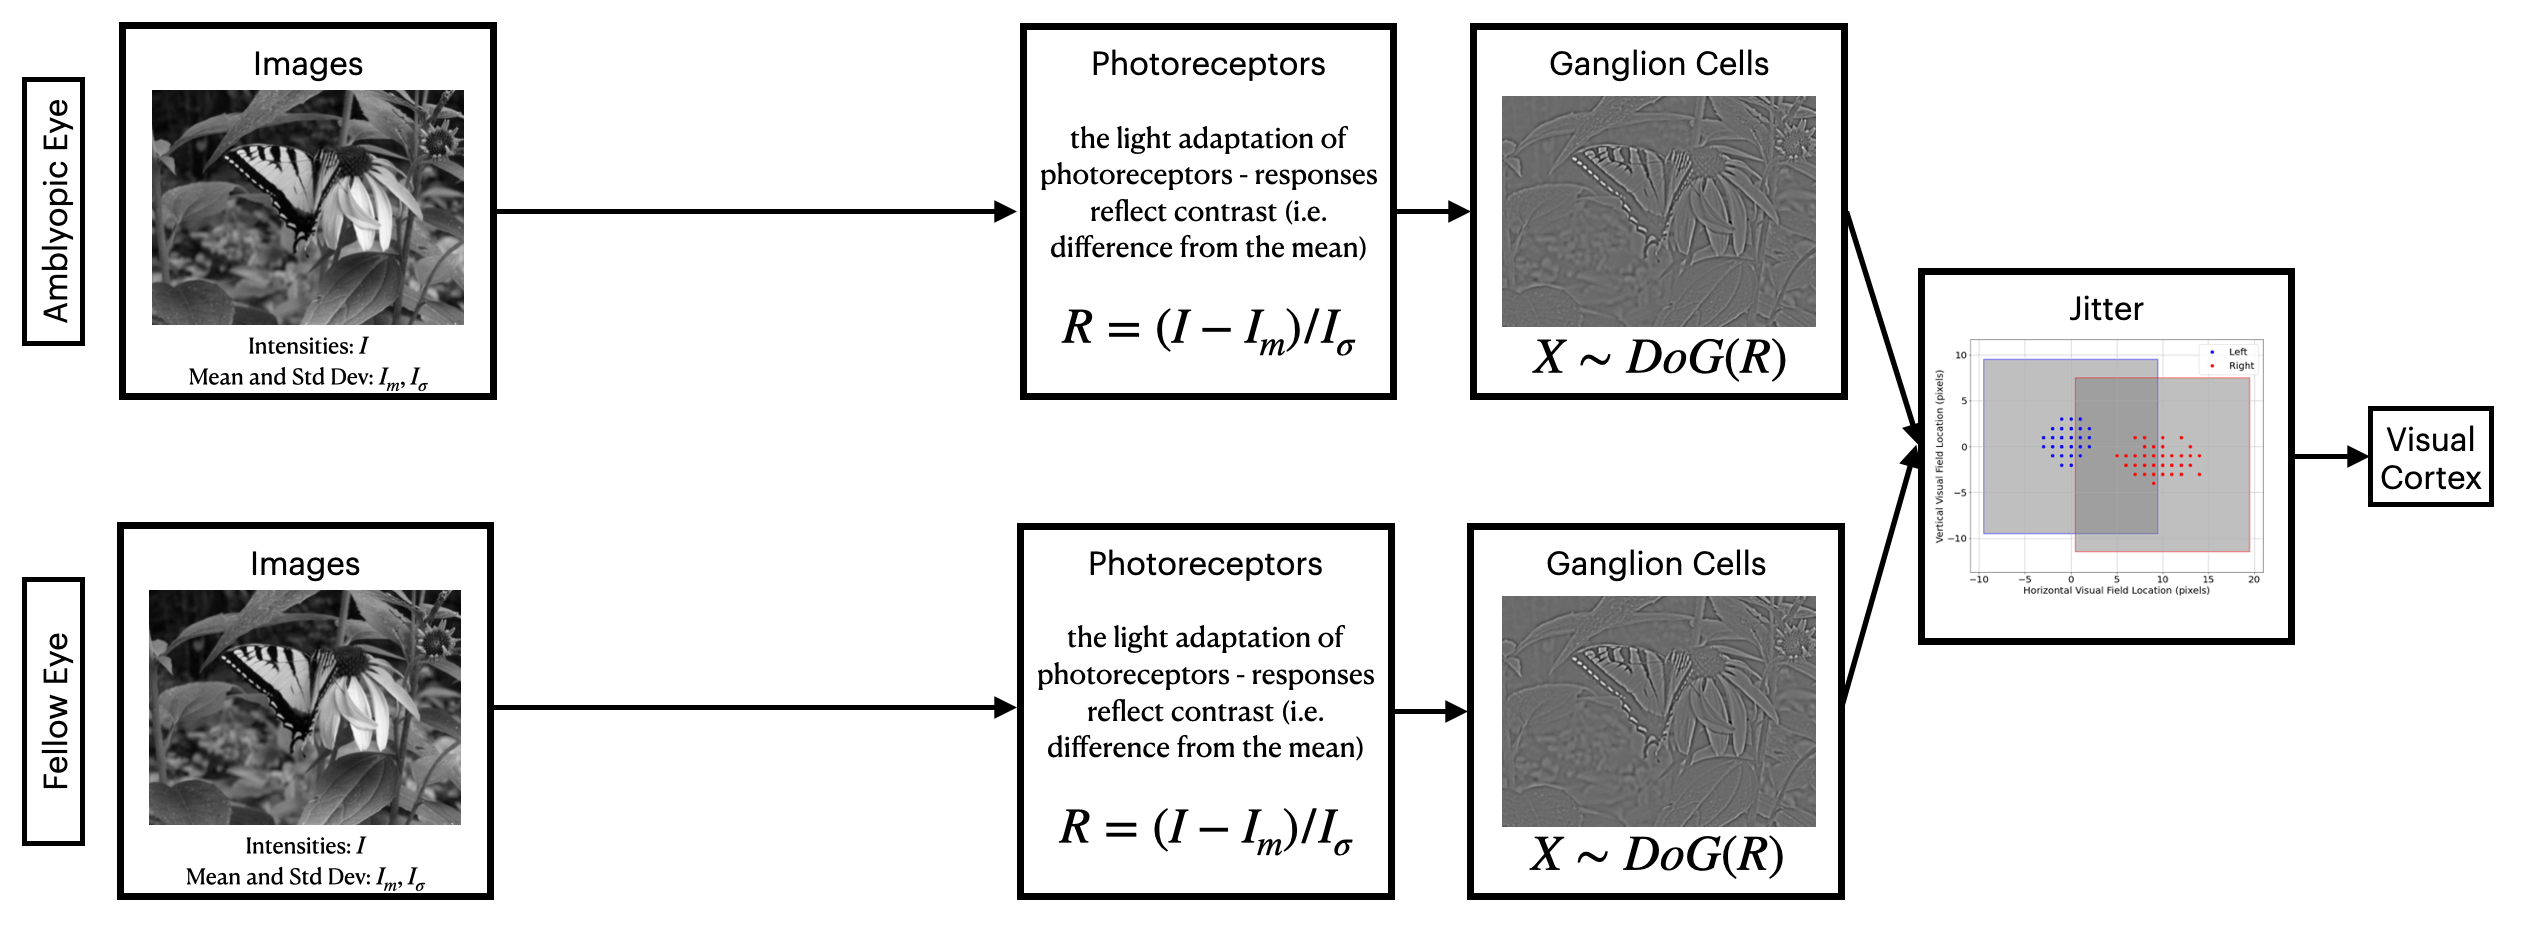

In [6]:
def fix(noise=[0.1,0.1],rf_size=19,
           number_of_neurons=10,
           total_time=8*day,
           save_interval=1*hour,
            mu_c=0,sigma_c=0,    
            mu_r=0,sigma_r=0,        
           eta=2e-6):
    
    
    im=[]
    im+=[pi5.filtered_images(base_image_file,
                        {'type':'norm'},
                        {'type':'dog','sd1':1,'sd2':3},   
                        verbose=False,
                        )
        ]
    im+=[pi5.filtered_images(base_image_file,
                        {'type':'norm'},
                        {'type':'dog','sd1':1,'sd2':3},
                        verbose=False,
                        )
        ]
                     
    
    
    pre1=pn.neurons.natural_images_with_jitter(im[0],
                                        rf_size=rf_size,
                                        sigma_r=0,
                                        sigma_c=0,
                                        verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(im[1],
                                       rf_size=rf_size,
                                       other_channel=pre1,
                                       mu_r=mu_r,mu_c=mu_c,
                                       sigma_r=sigma_r,sigma_c=sigma_c,
                                       verbose=False)
    
    


    pre1+=pn.neurons.process.add_noise_normal(0,noise[0])
    pre2+=pn.neurons.process.add_noise_normal(0,noise[1])

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    save_interval=save_interval

    sim=pn.simulation(total_time)

    sim.dt=200*ms

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]

@ray.remote
def run_one_continuous_fix(params,run=True,overwrite=False):
    import plasticnet as pn
    count,eta,noise,mu_c,mu_r,sigma_c,sigma_r,number_of_neurons,sfname=(
                                params.count,
                                params.eta,
                                params.noise,
                                params.mu_c,
                                params.mu_r,
                                params.sigma_c,
                                params.sigma_r,
                                params.number_of_neurons,
                                params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    seq=pn.Sequence()
    # deliberately use a standard deficit, with it's own eta and noise
    seq+=deficit(number_of_neurons=params.number_of_neurons,
                 mu_c=mu_c,sigma_c=sigma_c,
                mu_r=mu_r,sigma_r=sigma_r,) 

    seq+=fix(total_time=100*hour,
             save_interval=20*minute,number_of_neurons=params.number_of_neurons,
             eta=eta,noise=noise,mu_c=mu_c,sigma_c=sigma_c,
             mu_r=mu_r,sigma_r=sigma_r)

    if run:
        seq.run(display_hash=False)
        pn.save(sfname,seq) 
    
    return sfname
    

In [7]:
number_of_neurons=20
eta=1e-6
number_of_processes=8
ray.init(num_cpus=number_of_processes)

2025-02-24 12:44:07,895	INFO worker.py:1816 -- Started a local Ray instance.


Python version:,3.12.6
Ray version:,2.38.0


(pid=93229) Splikes version  0.1.4
(pid=93229) Plasticnet version  0.1.12


In [8]:
func=run_one_continuous_fix

noise_mat=linspace(0,1,11)

all_params=[]
for n,noise in enumerate(noise_mat):
    sfname=f'{base_sim_dir}/continuous fix {number_of_neurons} neurons noise {noise:.1f}.asdf'
    
    p=Struct()
    p.eta=eta
    p.number_of_neurons=number_of_neurons
    p.sfname=sfname
    p.mu_c=mu_c
    p.sigma_c=sigma_c
    p.mu_r=mu_r
    p.sigma_r=sigma_r
    
    p.noise=(noise,noise)
    
    all_params+=[p]

all_params=to_named_tuple(all_params)  

In [9]:
### premake the images
for params in tqdm(all_params):
    result=func.remote(params,run=False,overwrite=True)
    sfname=ray.get(result)
    print(sfname)

100%|████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.42it/s]

sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.0.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.1.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.2.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.3.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.4.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.5.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.6.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.7.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.8.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.9.asdf
sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 1.0.asdf


In [10]:
do_params=make_do_params(all_params,verbose=True)

11 sims
[params(eta=1e-06, number_of_neurons=20, sfname='sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.0.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.0, 0.0), count=0), params(eta=1e-06, number_of_neurons=20, sfname='sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.1.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.1), count=1), params(eta=1e-06, number_of_neurons=20, sfname='sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.2.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.2, 0.2), count=2), params(eta=1e-06, number_of_neurons=20, sfname='sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.3.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.30000000000000004, 0.30000000000000004), count=3), params(eta=1e-06, number_of_neurons=20, sfname='sims-2025-02-25 mu 9 sigma 9/continuous fix 20 neurons noise 0.4.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.4, 0.4), count=4), params(eta=1e-06, number_of_n

In [ ]:
results = [func.remote(p) for p in do_params]
sfnames=ray.get(results)

(run_one_continuous_fix pid=49928) [
(pid=49929) Splikes version  0.1.4
(pid=49929) Plasticnet version  0.1.12
(run_one_continuous_fix pid=49928) .
(run_one_continuous_fix pid=49925) [ [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(pid=49925) Splikes version  0.1.4 [repeated 6x across cluster]
(pid=49925) Plasticnet version  0.1.12 [repeated 6x across cluster]
(run_one_continuous_fix pid=49928) .] Sequence Time Elapsed...2 m, 15.19 s
(run_one_continuous_fix pid=49927) . [repeated 7x across cluster]
(run_one_continuous_fix pid=49928) [
(run_one_continuous_fix pid=49927) .] Sequence Time Elapsed...2 m, 16.19 s [repeated 7x across cluster]
(run_one_continuous_fix pid=49928) .
(run_one_continuous_fix pid=49925) [ [repeated 2x across cluster]
(run_one_continuous_fix pid=49925) .
(run_one_continuous

In [ ]:
assert func==run_one_continuous_fix
S=Storage()
for params in tqdm(all_params):
    sfname=params.sfname
    noise=params.noise[1]
    
    R=Results(sfname)
    idx1,idx2=[_[1] for _ in R.sequence_index]
    t=R.t/day
    recovery_rate_μ,recovery_rate_σ=μσ((R.ODI[idx2,:]-R.ODI[idx1,:])/(t[idx2]-t[idx1]))  
    
    S+=noise,recovery_rate_μ,recovery_rate_σ
    
noise,recovery_rate_μ,recovery_rate_σ=S.arrays()    


glasses_result=noise,recovery_rate_μ,recovery_rate_σ
savevars(f'{base_sim_dir}/glasses_results.asdf','glasses_result')    

  0%|          | 0/11 [00:00<?, ?it/s]

Saving sims-2024-05-27 mu 9 sigma 9/glasses_results.asdf...done.


In [ ]:
params.noise

(1.0, 1.0)

## Patch treatment

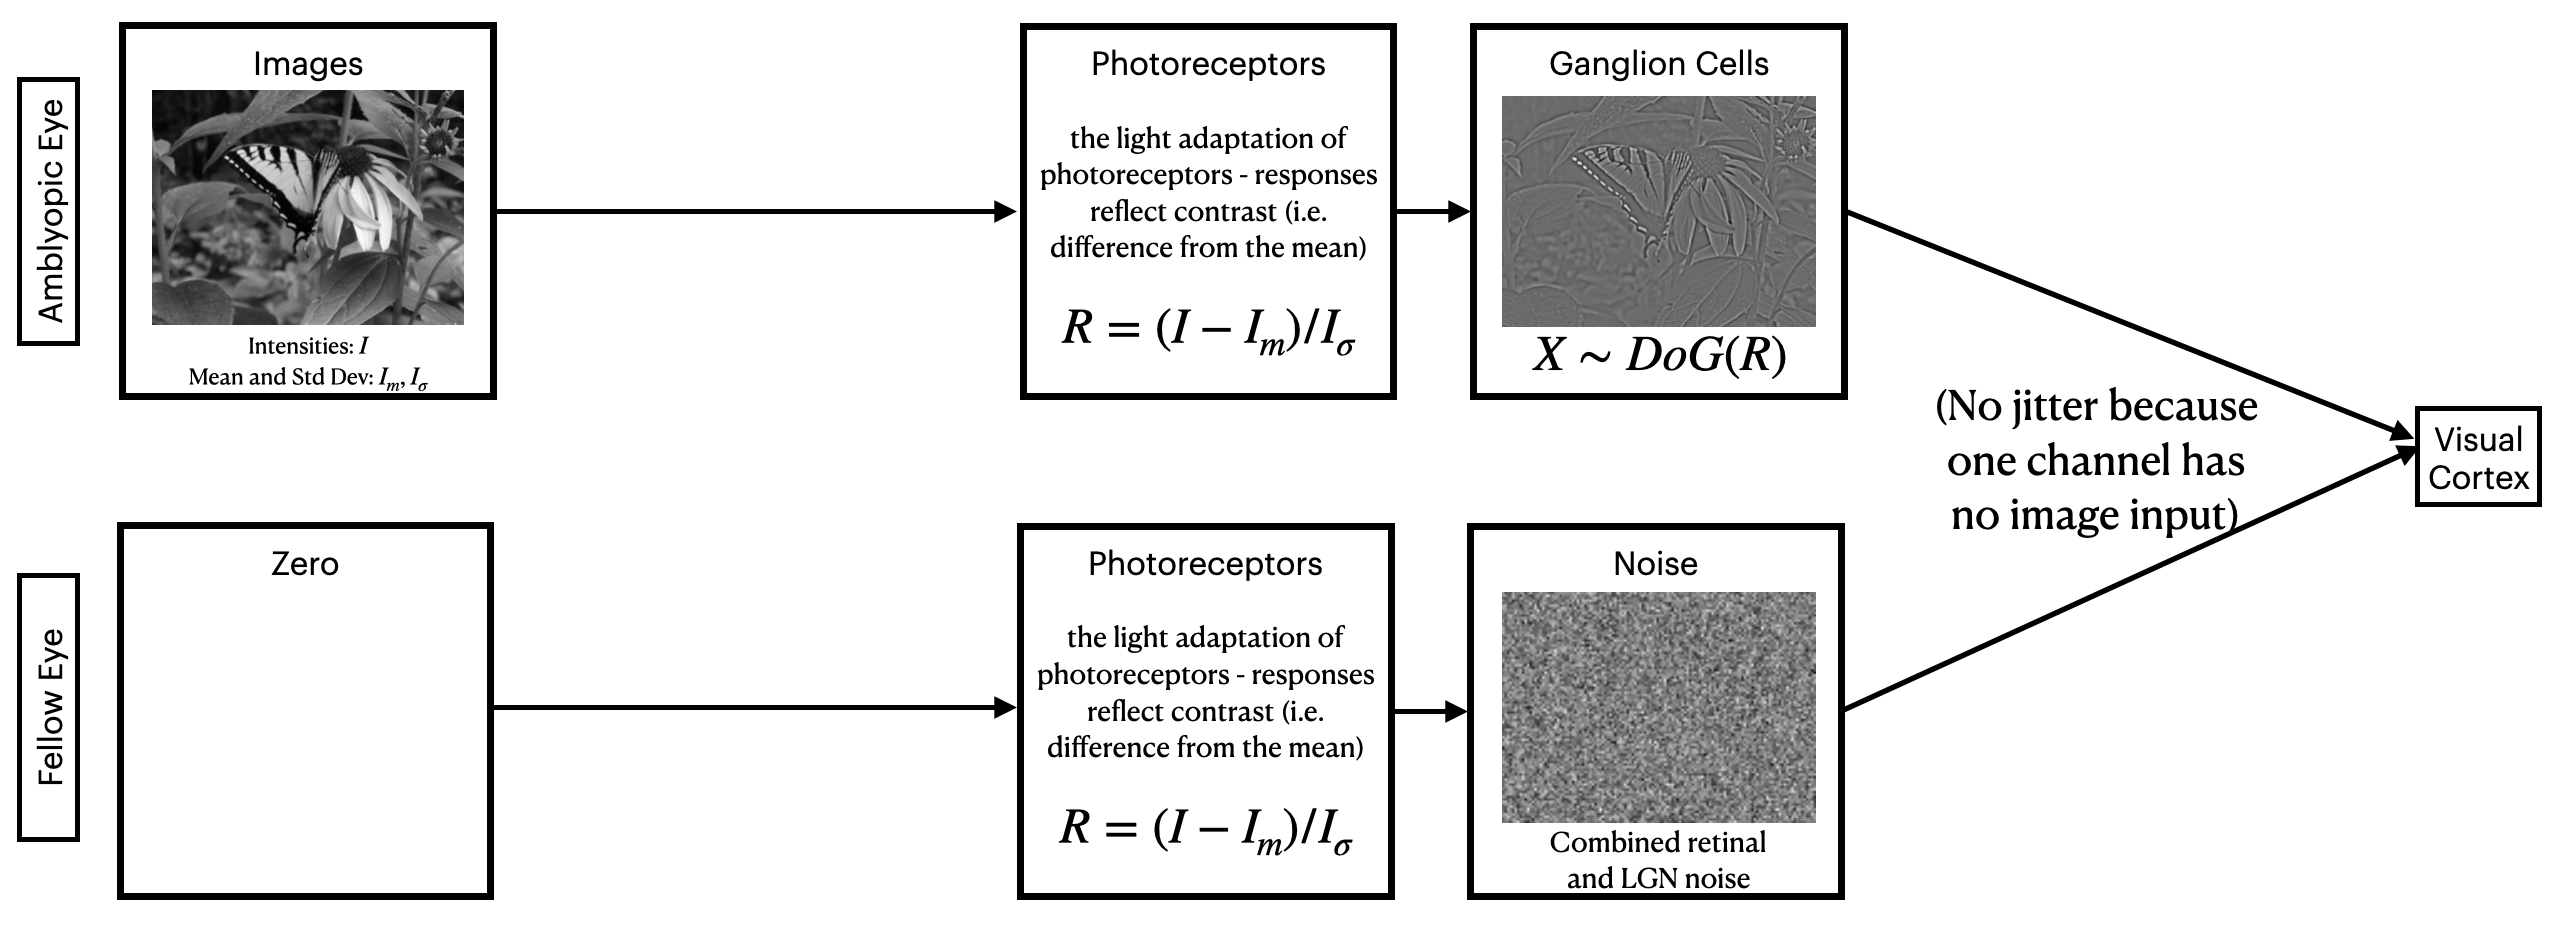

In [ ]:
def patch_treatment(noise=[0.1,0.1],rf_size=19,
                   number_of_neurons=20,
                   total_time=8*day,
                   save_interval=1*hour,
                   eta=2e-6,
                    mu_c=0,sigma_c=0,    
                    mu_r=0,sigma_r=0,        
                   ):
    

    im=[]
    im+=[pi5.filtered_images(base_image_file,
                        {'type':'norm'},
                        {'type':'dog','sd1':1,'sd2':3},   
                        verbose=False,
                        )
        ]
    im+=[pi5.filtered_images(base_image_file,
                        {'type':'norm'},
                        {'type':'dog','sd1':1,'sd2':3},   
                        verbose=False,
                        )
        ]
    
    
    pre1=pn.neurons.natural_images_with_jitter(im[0],
                                        rf_size=rf_size,
                                        sigma_r=0,
                                        sigma_c=0,
                                        verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(im[1],
                                       rf_size=rf_size,
                                       other_channel=pre1,
                                       mu_r=mu_r,mu_c=mu_c,
                                       sigma_r=sigma_r,sigma_c=sigma_c,
                                       verbose=False)


    pre1+=pn.neurons.process.add_noise_normal(0,noise[0])

    pre2+=pn.neurons.process.scale_shift(0.0,0) # zero out signal
    pre2+=pn.neurons.process.add_noise_normal(0,noise[1])

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    save_interval=save_interval

    sim=pn.simulation(total_time)

    sim.dt=200*ms

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]

@ray.remote
def run_one_continuous_patch(params,run=True,overwrite=False):
    import plasticnet as pn
    count,eta,noise,mu_c,sigma_c,mu_r,sigma_r,number_of_neurons,sfname=(
        params.count,
        params.eta,
        params.noise,
        params.mu_c,
        params.sigma_c,
        params.mu_r,
        params.sigma_r,
        params.number_of_neurons,params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    
    seq=pn.Sequence()
    # deliberately use a standard deficit, with it's own eta and noise
    seq+=deficit(number_of_neurons=params.number_of_neurons,
                mu_c=mu_c,sigma_c=sigma_c,
                mu_r=mu_r,sigma_r=sigma_r,) 
    
    seq+=patch_treatment(noise=noise,
               total_time=100*hour,number_of_neurons=params.number_of_neurons,
               eta=eta,
               mu_c=mu_c,sigma_c=sigma_c,
               mu_r=mu_r,sigma_r=sigma_r,
               save_interval=20*minute)

    if run:
        seq.run(display_hash=False,print_time=True)
        pn.save(sfname,seq) 
    
    return sfname
        

In [ ]:
func=run_one_continuous_patch

closed_eye_noise_mat=linspace(0,1,21)

all_params=[]
for n,noise in enumerate(closed_eye_noise_mat):
    sfname=f'{base_sim_dir}/continuous patch {number_of_neurons} neurons noise {noise:.1f}.asdf'
    
    p=Struct()
    p.eta=eta
    p.number_of_neurons=number_of_neurons
    p.sfname=sfname
    p.mu_c=mu_c
    p.sigma_c=sigma_c
    p.mu_r=mu_r
    p.sigma_r=sigma_r
    
    p.noise=(0.1,noise)
    
    all_params+=[p]

all_params=to_named_tuple(all_params)  


In [ ]:
do_params=make_do_params(all_params,verbose=True)

21 sims
[params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous patch 20 neurons noise 0.0.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.0), count=0), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous patch 20 neurons noise 0.1.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.05), count=1), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous patch 20 neurons noise 0.1.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.1), count=2), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous patch 20 neurons noise 0.2.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.15000000000000002), count=3), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous patch 20 neurons noise 0.2.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.2), count=4)] ... [params(eta=1e-06, number_of_n

In [ ]:
results = [func.remote(p) for p in do_params]
sfnames=ray.get(results)

(run_one_continuous_patch pid=49928) [
(run_one_continuous_patch pid=49927) .
(run_one_continuous_patch pid=49925) [ [repeated 7x across cluster]
(run_one_continuous_patch pid=49926) .] Sequence Time Elapsed...2 m, 15.44 s
(run_one_continuous_patch pid=49924) . [repeated 7x across cluster]
(run_one_continuous_patch pid=49926) [
(run_one_continuous_patch pid=49924) .] Sequence Time Elapsed...2 m, 16.41 s [repeated 7x across cluster]
(run_one_continuous_patch pid=49926) .
(run_one_continuous_patch pid=49924) [ [repeated 7x across cluster]
(run_one_continuous_patch pid=49922) .
(run_one_continuous_patch pid=49926) .] Sequence Time Elapsed...2 m, 15.11 s
(run_one_continuous_patch pid=49924) . [repeated 6x across cluster]
(run_one_continuous_patch pid=49922) .] Sequence Time Elapsed...2 m, 15.10 s
(run_one_continuous_patch pid=49926) [
(run_one_continuous_patch pid=49926) .
(run_one_continuous_patch pid=49924) .] Sequence Time Elapsed...2 m, 15.70 s [repeated 6x across cluster]
(run_one_con

In [ ]:
assert func==run_one_continuous_patch
S=Storage()
for params in tqdm(all_params):
    sfname=params.sfname
    noise=params.noise[1]
    
    R=Results(sfname)

    
    idx1,idx2=[_[1] for _ in R.sequence_index]
    t=R.t/day
    recovery_rate_μ,recovery_rate_σ=μσ((R.ODI[idx2,:]-R.ODI[idx1,:])/(t[idx2]-t[idx1]))  
    
    S+=noise,recovery_rate_μ,recovery_rate_σ    
        
noise,recovery_rate_μ,recovery_rate_σ=S.arrays()

patch_result=noise,recovery_rate_μ,recovery_rate_σ
savevars(f'{base_sim_dir}/patch_results.asdf','patch_result')

  0%|          | 0/21 [00:00<?, ?it/s]

Saving sims-2024-05-27 mu 9 sigma 9/patch_results.asdf...done.


In [ ]:
params.noise

(0.1, 1.0)

## Atropine Treatment

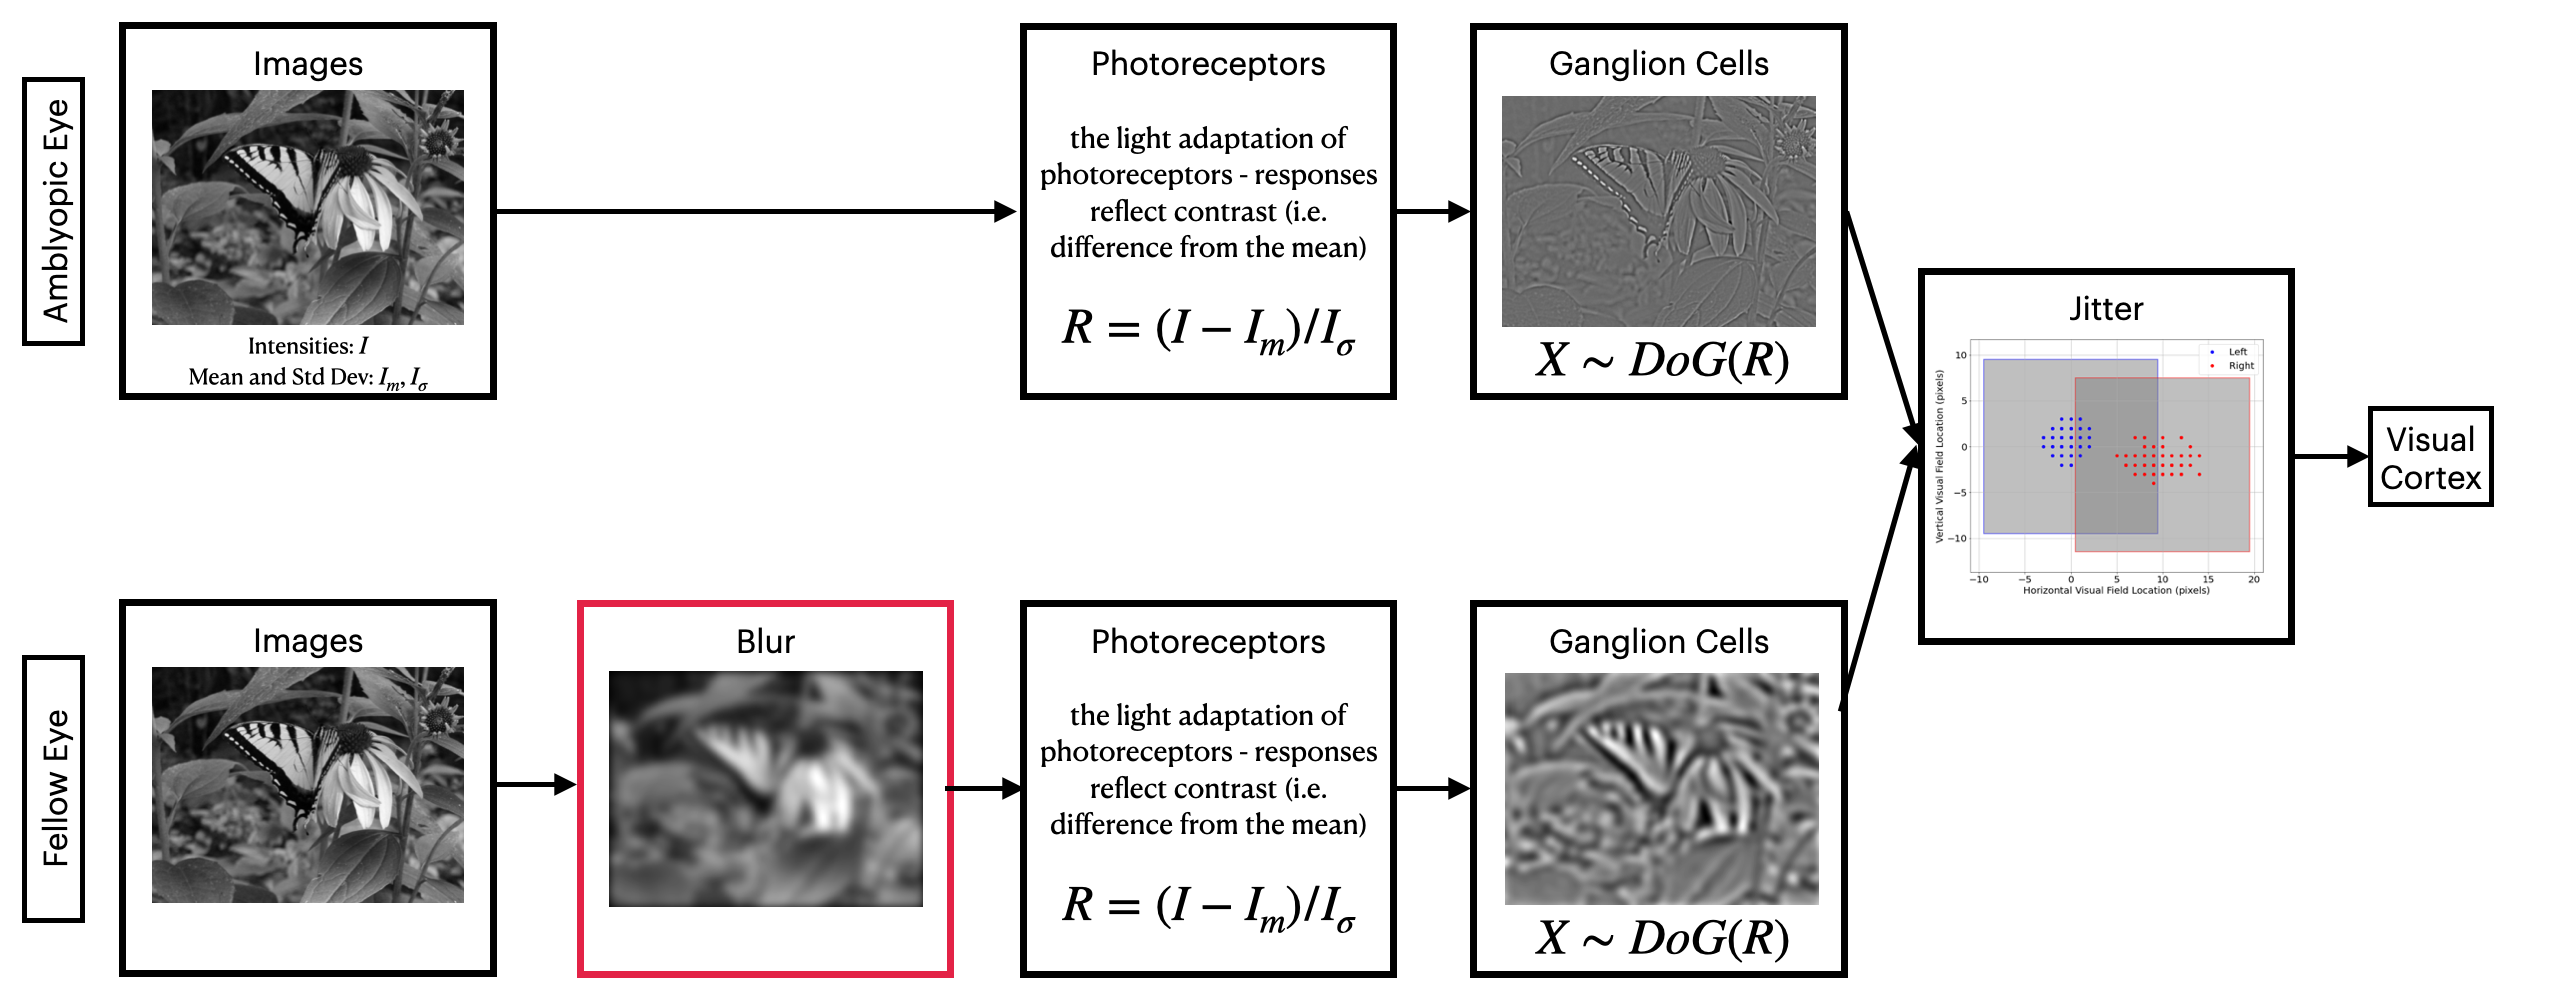

In [ ]:
def atropine_treatment(noise=[0.1,0.1],
                       blur=[-1,-1],
                       rf_size=19,
           number_of_neurons=10,
           total_time=8*day,
           save_interval=1*hour,
           eta=2e-6,
                    mu_c=0,sigma_c=0,    
                    mu_r=0,sigma_r=0,        
                      ):
    
    
    im=[]
    for b in blur:
        if b<0:
            im+=[pi5.filtered_images(base_image_file,
                                    {'type':'norm'},
                                    {'type':'dog','sd1':1,'sd2':3},   
                                    verbose=False,
                                    )
                ]
        else:
            im+=[pi5.filtered_images(base_image_file,
                                    {'type':'blur','size':b},
                                    {'type':'norm'},
                                    {'type':'dog','sd1':1,'sd2':3},   
                                    verbose=False,
                                    )
                ]
            
    pre1=pn.neurons.natural_images_with_jitter(im[0],
                                        rf_size=rf_size,
                                        sigma_r=0,
                                        sigma_c=0,
                                        verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(im[1],
                                       rf_size=rf_size,
                                       other_channel=pre1,
                                       mu_r=mu_r,mu_c=mu_c,
                                       sigma_r=sigma_r,sigma_c=sigma_c,
                                       verbose=False)

    pre1+=pn.neurons.process.add_noise_normal(0,noise[0])

    sigma=noise
    pre2+=pn.neurons.process.add_noise_normal(0,noise[1])

    pre=pre1+pre2

    post=default_post(number_of_neurons)
    c=default_bcm(pre,post)
    c.eta=eta

    sim=pn.simulation(total_time)
    sim.dt=200*ms

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]




@ray.remote
def run_one_continuous_atropine(params,run=True,overwrite=False):
    import plasticnet as pn
    count,blur,eta,noise,mu_c,sigma_c,mu_r,sigma_r,number_of_neurons,sfname=(
        params.count,
            params.blur,params.eta,params.noise,
        params.mu_c,params.sigma_c,params.mu_r,params.sigma_r,
                params.number_of_neurons,params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname
    
    
    seq=pn.Sequence()
    # deliberately use a standard deficit, with it's own eta and noise
    seq+=deficit(number_of_neurons=params.number_of_neurons,
                mu_c=mu_c,sigma_c=sigma_c,
                mu_r=mu_r,sigma_r=sigma_r,) 

    seq+=atropine_treatment(blur=(-1,blur),
                   noise=noise,
                   total_time=100*hour,
                    number_of_neurons=params.number_of_neurons,
                   eta=eta,
                   mu_c=mu_c,sigma_c=sigma_c,
                   mu_r=mu_r,sigma_r=sigma_r,
                   save_interval=20*minute)
    

    if run:
        seq.run(display_hash=False)
        pn.save(sfname,seq) 
    
    return sfname
    

In [ ]:
func=run_one_continuous_atropine


atropine_blur_mat=linspace(0,6,21)
closed_eye_noise_mat=linspace(0,1,11)

all_params=[]
for b,blur in enumerate(atropine_blur_mat):
    for n,noise in enumerate(closed_eye_noise_mat):
        sfname=f'{base_sim_dir}/continuous atropine {number_of_neurons} neurons noise {noise:.1f} blur {blur:0.1f}.asdf'

        p=Struct()
        p.eta=eta
        p.number_of_neurons=number_of_neurons
        p.sfname=sfname
        p.mu_c=mu_c
        p.sigma_c=sigma_c
        p.mu_r=mu_r
        p.sigma_r=sigma_r

        p.noise=(0.1,noise)
        p.blur=blur

        all_params+=[p]

all_params=to_named_tuple(all_params)  

In [ ]:
do_params=make_do_params(all_params,verbose=True)

231 sims
[params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous atropine 20 neurons noise 0.0 blur 0.0.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.0), blur=0.0, count=0), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous atropine 20 neurons noise 0.1 blur 0.0.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.1), blur=0.0, count=1), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous atropine 20 neurons noise 0.2 blur 0.0.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.2), blur=0.0, count=2), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous atropine 20 neurons noise 0.3 blur 0.0.asdf', mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, noise=(0.1, 0.30000000000000004), blur=0.0, count=3), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous atropine 20 neurons noise 0.4 blur 0.0.asdf', 

In [ ]:
### premake the images
for params in tqdm(all_params):
    result=func.remote(params,run=False,overwrite=True)
    sfname=ray.get(result)

  0%|          | 0/231 [00:00<?, ?it/s]

In [ ]:
results = [func.remote(p) for p in do_params]
sfnames=ray.get(results)

(run_one_continuous_atropine pid=49928) [
(run_one_continuous_atropine pid=49926) .
(run_one_continuous_atropine pid=49925) [ [repeated 7x across cluster]
(run_one_continuous_atropine pid=49926) .] Sequence Time Elapsed...2 m, 15.52 s
(run_one_continuous_atropine pid=49929) . [repeated 7x across cluster]
(run_one_continuous_atropine pid=49926) [
(run_one_continuous_atropine pid=49929) .] Sequence Time Elapsed...2 m, 16.83 s [repeated 7x across cluster]
(run_one_continuous_atropine pid=49926) .
(run_one_continuous_atropine pid=49929) [ [repeated 7x across cluster]
(run_one_continuous_atropine pid=49928) .
(run_one_continuous_atropine pid=49928) .] Sequence Time Elapsed...2 m, 14.74 s
(run_one_continuous_atropine pid=49929) . [repeated 6x across cluster]
(run_one_continuous_atropine pid=49926) .] Sequence Time Elapsed...2 m, 14.97 s
(run_one_continuous_atropine pid=49928) [
(run_one_continuous_atropine pid=49924) .] Sequence Time Elapsed...2 m, 15.26 s [repeated 6x across cluster]
(run_o

In [ ]:
assert func==run_one_continuous_atropine
S=Storage()
for params in tqdm(all_params):
    sfname=params.sfname
    noise=params.noise[1]
    blur=params.blur
    
    R=Results(sfname)

    
    idx1,idx2=[_[1] for _ in R.sequence_index]
    t=R.t/day
    recovery_rate_μ,recovery_rate_σ=μσ((R.ODI[idx2,:]-R.ODI[idx1,:])/(t[idx2]-t[idx1]))  
    
    S+=noise,blur,recovery_rate_μ,recovery_rate_σ    
        
noise,blur,recovery_rate_μ,recovery_rate_σ=S.arrays()



  0%|          | 0/231 [00:00<?, ?it/s]

In [ ]:
blur

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0.3,
       0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.6, 0.6, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2,
       1.2, 1.2, 1.2, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 1.8, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.4, 2.4, 2.4,
       2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.7, 2.7, 2.7, 2.7, 2.7,
       2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 3. , 3. , 3. , 3. , 3. , 3. , 3. ,
       3. , 3. , 3. , 3. , 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3,
       3.3, 3.3, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6,
       3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 4.2, 4.2,
       4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.2, 4.5, 4.5, 4.5, 4.5,
       4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.5, 4.8, 4.8, 4.8, 4.8, 4.

In [ ]:
blur_orig=blur
noise_orig=noise

In [ ]:
noise_N=len(closed_eye_noise_mat)
blur_N=len(atropine_blur_mat)

noise=noise.reshape(blur_N,noise_N)
noise,blur,recovery_rate_μ,recovery_rate_σ=[_.reshape(blur_N,noise_N).T for _ in (noise,blur,recovery_rate_μ,recovery_rate_σ)]



In [ ]:
blur

array([[0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ],
       [0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ],
       [0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ],
       [0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ],
       [0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ],
       [0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ],
       [0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ],
       [0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6,
        3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ],
       [0. , 0.3, 0.6, 0

In [ ]:
atropine_result=noise,blur,recovery_rate_μ,recovery_rate_σ

savevars(f'{base_sim_dir}/atropine_results.asdf','atropine_result')

Saving sims-2024-05-27 mu 9 sigma 9/atropine_results.asdf...done.


## Contrast, then Contrast with Mask

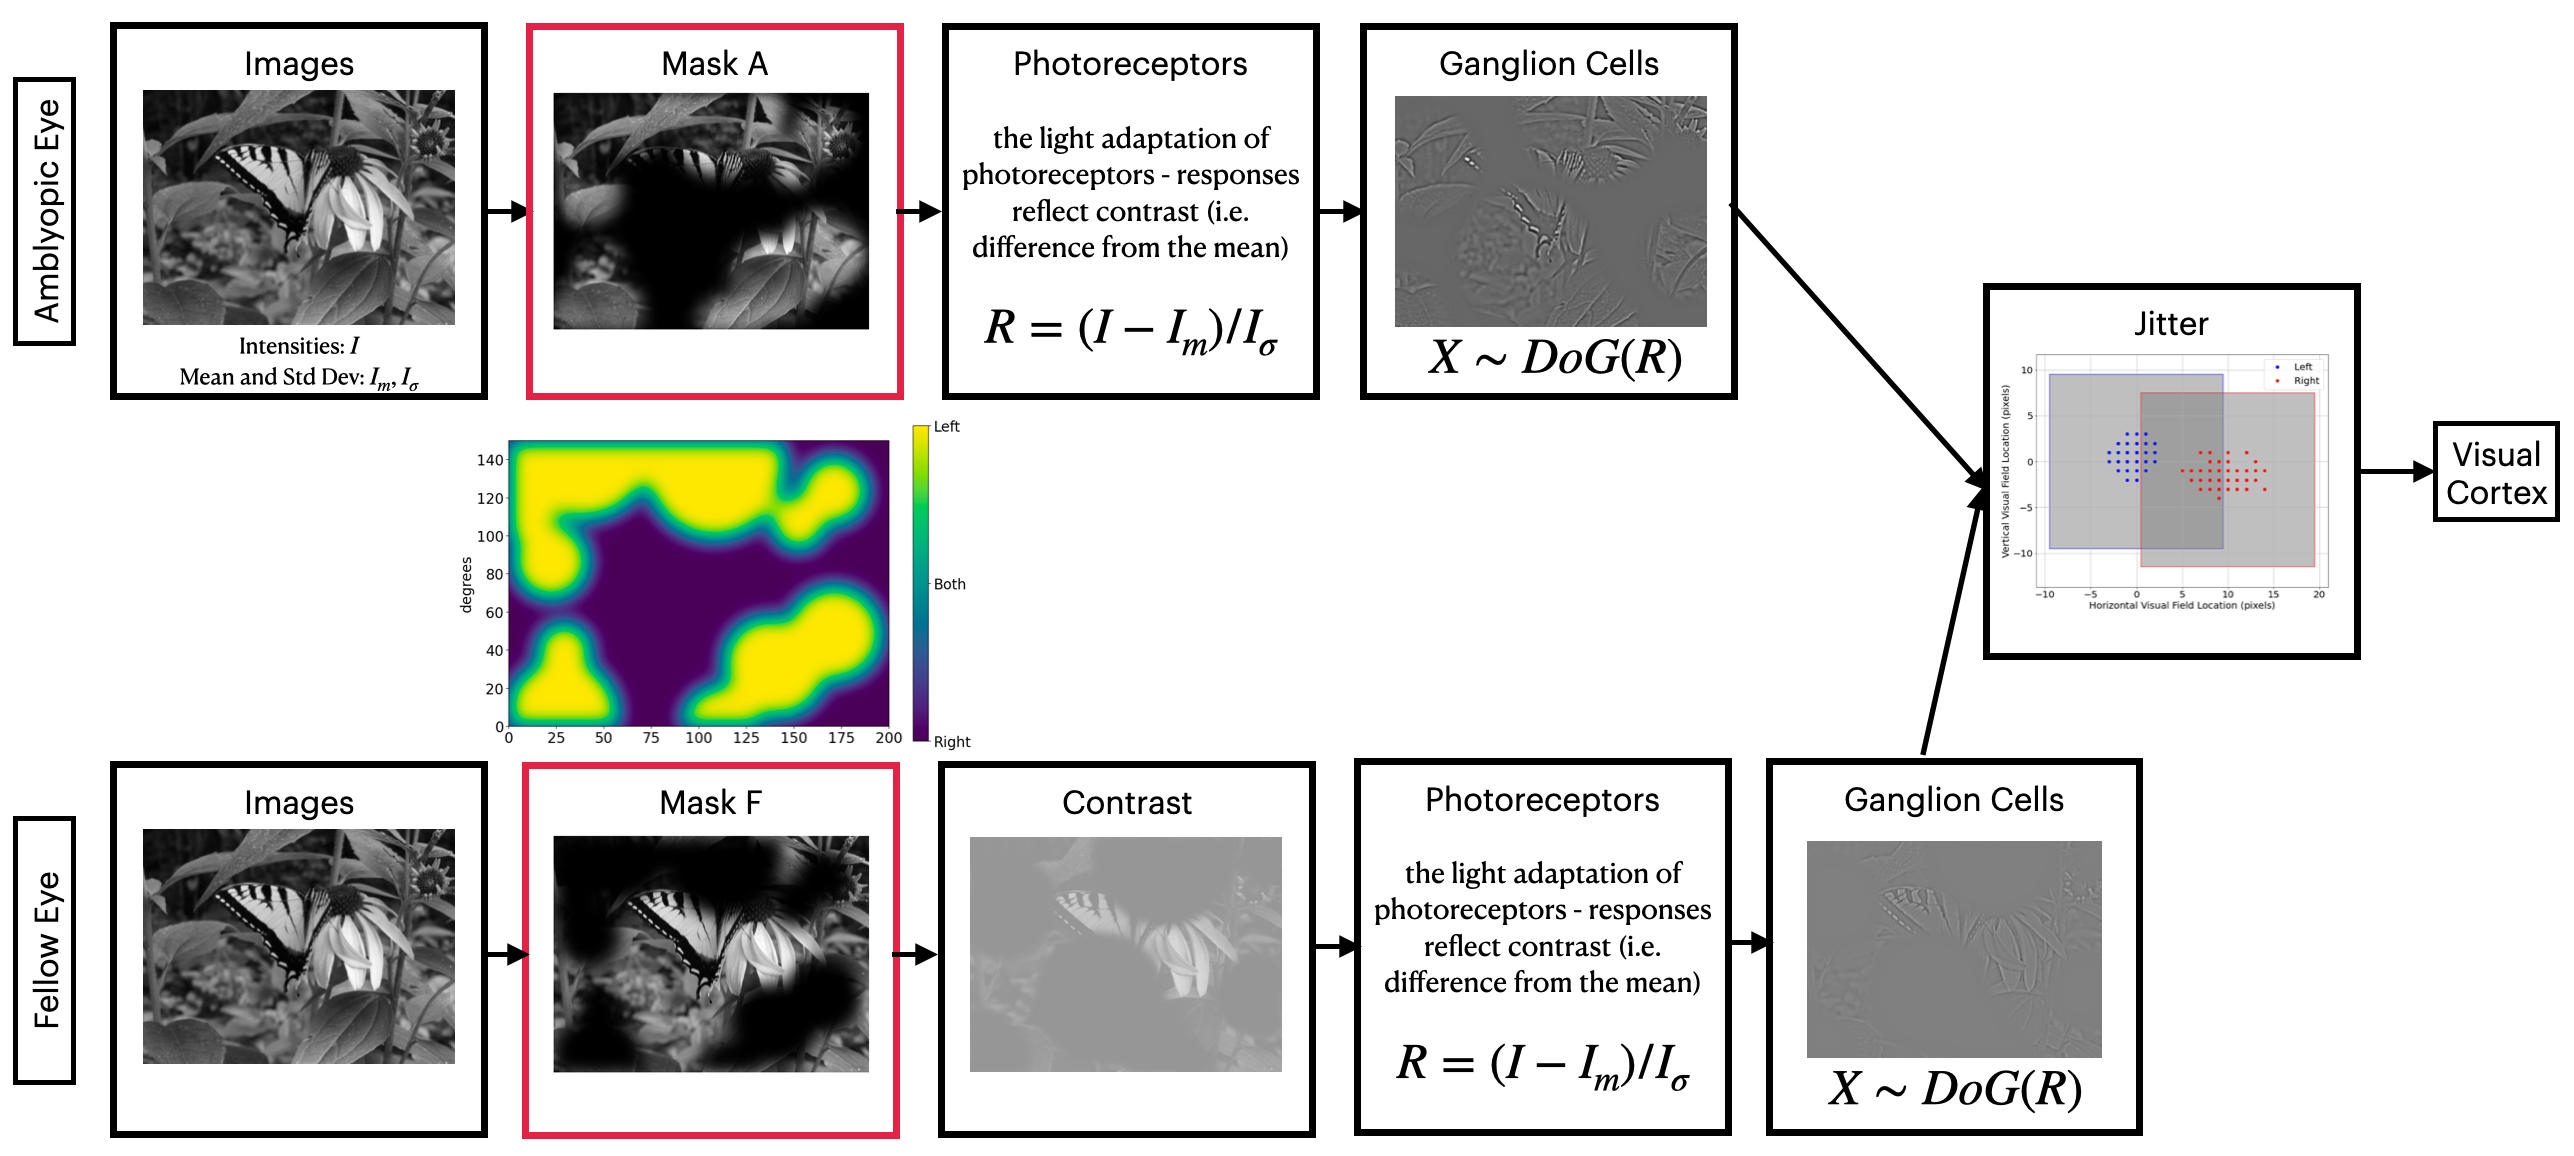

In [ ]:
def mask_contrast_treatment(contrast=[1,1],noise=[0.1,0.1],
              rf_size=19,eta=5e-6,
                    mu_c=0,sigma_c=0,    
                    mu_r=0,sigma_r=0,        
              f=30,  # size of the blur for mask, which is a measure of overlap
           number_of_neurons=20,
           total_time=8*day,
           save_interval=1*hour,
             mask=None,
             blur=(-1,-1)):
    
    
    if not f in [10,30,50,70,90]:
        raise ValueError("Unknown f %s" % str(f))

        
        
    im=[]
    if not mask:
        for (b,c) in zip(blur,contrast):
            if b<0:
                im+=[pi5.filtered_images(base_image_file,
                                        {'type':'mask',
                                         'name':'', 
                                        'seed':101,'apply_to_average':True},
                                        {'type':'norm'},
                                        {'type':'dog','sd1':1,'sd2':3},   
                                        verbose=False,
                                        )
                    ]
            else:
                im+=[pi5.filtered_images(base_image_file,
                                        {'type':'mask',
                                         'name':'', 
                                        'seed':101,'apply_to_average':True},
                                        {'type':'blur','size':b},
                                        {'type':'norm'},
                                        {'type':'dog','sd1':1,'sd2':3},   
                                        verbose=False,
                                        )
                    ]
    else:
        for [b,mask_name,c] in zip(blur,['A','F'],contrast):
            if b<0:
                im+=[pi5.filtered_images(base_image_file,
                                        {'type':'mask',
                                         'name':f'bblais-masks-20240511/2024-05-11-*-{mask_name}-fsig{int(f)}.png', 
                                        'seed':101,'apply_to_average':True},
                                        {'type':'norm'},
                                        {'type':'dog','sd1':1,'sd2':3},   
                                        verbose=False,
                                         )
                    ]
            else:
                im+=[pi5.filtered_images(base_image_file,
                                        {'type':'mask',
                                         'name':f'bblais-masks-20240511/2024-05-11-*-{mask_name}-fsig{int(f)}.png', 
                                        'seed':101,'apply_to_average':True},
                                        {'type':'blur','size':b},
                                        {'type':'norm'},
                                        {'type':'dog','sd1':1,'sd2':3},   
                                        verbose=False,
                                        )
                     ]
        
        
        
    pre1=pn.neurons.natural_images_with_jitter(im[0],
                                        rf_size=rf_size,
                                        sigma_r=0,
                                        sigma_c=0,
                                        verbose=False)

    pre2=pn.neurons.natural_images_with_jitter(im[1],
                                       rf_size=rf_size,
                                       other_channel=pre1,
                                       mu_r=mu_r,mu_c=mu_c,
                                       sigma_r=sigma_r,sigma_c=sigma_c,
                                       verbose=False)

    if contrast[0]!=1:
        pre1+=pn.neurons.process.scale_shift(contrast[0],0)

    pre1+=pn.neurons.process.add_noise_normal(0,noise[0])

    
    if contrast[1]!=1:
        pre2+=pn.neurons.process.scale_shift(contrast[1],0)
    pre2+=pn.neurons.process.add_noise_normal(0,noise[1])

    pre=pre1+pre2

    post=pn.neurons.linear_neuron(number_of_neurons)
    post+=pn.neurons.process.sigmoid(-1,50)

    c=pn.connections.BCM(pre,post,[-.1,.1],[.1,.2])
    c.eta=eta
    c.tau=100*second

    save_interval=save_interval

    sim=pn.simulation(total_time)

    sim.dt=200*ms

    sim.monitor(post,['output'],save_interval)
    sim.monitor(c,['weights','theta'],save_interval)

    sim+=pn.grating_response(print_time=False)

    return sim,[pre,post],[c]


    

@ray.remote
def run_one_continuous_mask(params,run=True,overwrite=False):
    import plasticnet as pn
    count,eta,contrast,mask,f,mu_c,sigma_c,mu_r,sigma_r,number_of_neurons,sfname=(
        params.count,params.eta,params.contrast,params.mask,params.f,
        params.mu_c,params.sigma_c,params.mu_r,params.sigma_r,
        params.number_of_neurons,params.sfname)
    
    if not overwrite and os.path.exists(sfname):
        return sfname

    
    seq=pn.Sequence()
    # deliberately use a standard deficit, with it's own eta and noise
    seq+=deficit(number_of_neurons=params.number_of_neurons,
                mu_c=mu_c,sigma_c=sigma_c,
                mu_r=mu_r,sigma_r=sigma_r,
                )

    seq+=mask_contrast_treatment(f=f,
                   mask=mask,
                   contrast=contrast,
                   total_time=100*hour,
                   eta=eta,
                mu_c=mu_c,sigma_c=sigma_c,
                mu_r=mu_r,sigma_r=sigma_r,
                   save_interval=20*minute)

    if run:
        seq.run(display_hash=False,print_time=True)
        pn.save(sfname,seq) 

    
    return sfname
    
    

In [ ]:
func=run_one_continuous_mask


contrast_mat=linspace(0,1,21)
f_mat=array([10,30,50,70,90])


all_params=[]
for c,contrast in enumerate(contrast_mat):
    sfname=f'{base_sim_dir}/continuous contrast {number_of_neurons} neurons contrast {contrast:.2f}.asdf'

    p=Struct()
    p.eta=eta
    p.number_of_neurons=number_of_neurons
    p.sfname=sfname

    p.contrast=(1,contrast)
    p.mask=0
    p.f=10. # not used when mask=0
    p.mu_c=mu_c
    p.sigma_c=sigma_c
    p.mu_r=mu_r
    p.sigma_r=sigma_r

    all_params+=[p]

all_params=to_named_tuple(all_params)  

In [ ]:
do_params=make_do_params(all_params,verbose=True)

21 sims
[params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.00.asdf', contrast=(1, 0.0), mask=0, f=10.0, mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, count=0), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.05.asdf', contrast=(1, 0.05), mask=0, f=10.0, mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, count=1), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.10.asdf', contrast=(1, 0.1), mask=0, f=10.0, mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, count=2), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.15.asdf', contrast=(1, 0.15000000000000002), mask=0, f=10.0, mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, count=3), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.20.asdf

In [ ]:
### premake the images
for params in tqdm(all_params):
    result=func.remote(params,run=False,overwrite=True)
    sfname=ray.get(result)

  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
results = [func.remote(p) for p in do_params]
sfnames=ray.get(results)

(run_one_continuous_mask pid=49928) [
(run_one_continuous_mask pid=49922) .
(run_one_continuous_mask pid=49925) [ [repeated 7x across cluster]
(run_one_continuous_mask pid=49922) .] Sequence Time Elapsed...2 m, 10.78 s
(run_one_continuous_mask pid=49928) . [repeated 7x across cluster]
(run_one_continuous_mask pid=49922) [
(run_one_continuous_mask pid=49928) .] Sequence Time Elapsed...2 m, 11.66 s [repeated 7x across cluster]
(run_one_continuous_mask pid=49926) .
(run_one_continuous_mask pid=49928) [ [repeated 7x across cluster]
(run_one_continuous_mask pid=49922) .
(run_one_continuous_mask pid=49922) .] Sequence Time Elapsed...2 m, 10.21 s
(run_one_continuous_mask pid=49927) . [repeated 6x across cluster]
(run_one_continuous_mask pid=49926) .] Sequence Time Elapsed...2 m, 10.14 s
(run_one_continuous_mask pid=49922) [
(run_one_continuous_mask pid=49926) .
(run_one_continuous_mask pid=49927) .] Sequence Time Elapsed...2 m, 11.31 s [repeated 6x across cluster]
(run_one_continuous_mask pid

In [ ]:
assert func==run_one_continuous_mask
S=Storage()
for params in tqdm(all_params):
    sfname=params.sfname
    contrast=params.contrast[1]
    
    R=Results(sfname)

    
    idx1,idx2=[_[1] for _ in R.sequence_index]
    t=R.t/day
    recovery_rate_μ,recovery_rate_σ=μσ((R.ODI[idx2,:]-R.ODI[idx1,:])/(t[idx2]-t[idx1]))  
    
    S+=contrast,recovery_rate_μ,recovery_rate_σ    
        
contrast,recovery_rate_μ,recovery_rate_σ=S.arrays()

contrast_result=contrast,recovery_rate_μ,recovery_rate_σ

savevars(f'{base_sim_dir}/contrast_results.asdf','contrast_result')

  0%|          | 0/21 [00:00<?, ?it/s]

Saving sims-2024-05-27 mu 9 sigma 9/contrast_results.asdf...done.


## Contrast with Mask

In [ ]:
func=run_one_continuous_mask


contrast_mat=linspace(0,1,21)
f_mat=array([10,30,50,70,90])

all_params=[]
for c,contrast in enumerate(contrast_mat):
    for fi,f in enumerate(f_mat):
    
        sfname=f'{base_sim_dir}/continuous contrast {number_of_neurons} neurons contrast {contrast:.2f} mask f {f}.asdf'

        p=Struct()
        p.eta=eta
        p.number_of_neurons=number_of_neurons
        p.sfname=sfname

        p.contrast=(1,contrast)
        p.mask=1
        p.f=f
        p.mu_c=mu_c
        p.sigma_c=sigma_c
        p.mu_r=mu_r
        p.sigma_r=sigma_r

        all_params+=[p]

all_params=to_named_tuple(all_params)  



In [ ]:
do_params=make_do_params(all_params,verbose=True)

105 sims
[params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.00 mask f 10.asdf', contrast=(1, 0.0), mask=1, f=10, mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, count=0), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.00 mask f 30.asdf', contrast=(1, 0.0), mask=1, f=30, mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, count=1), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.00 mask f 50.asdf', contrast=(1, 0.0), mask=1, f=50, mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, count=2), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons contrast 0.00 mask f 70.asdf', contrast=(1, 0.0), mask=1, f=70, mu_c=9, sigma_c=9, mu_r=0, sigma_r=0, count=3), params(eta=1e-06, number_of_neurons=20, sfname='sims-2024-05-27 mu 9 sigma 9/continuous contrast 20 neurons co

In [ ]:
### premake the images
for params in tqdm(all_params):
    result=func.remote(params,run=False,overwrite=True)
    sfname=ray.get(result)

  0%|          | 0/105 [00:00<?, ?it/s]

In [ ]:
results = [func.remote(p) for p in do_params]
sfnames=ray.get(results)

(run_one_continuous_mask pid=49928) [
(run_one_continuous_mask pid=49922) .
(run_one_continuous_mask pid=49925) [ [repeated 7x across cluster]
(run_one_continuous_mask pid=49922) .] Sequence Time Elapsed...2 m, 11.32 s
(run_one_continuous_mask pid=49925) . [repeated 7x across cluster]
(run_one_continuous_mask pid=49922) [
(run_one_continuous_mask pid=49925) .] Sequence Time Elapsed...2 m, 12.59 s [repeated 7x across cluster]
(run_one_continuous_mask pid=49922) .
(run_one_continuous_mask pid=49925) [ [repeated 7x across cluster]
(run_one_continuous_mask pid=49927) .
(run_one_continuous_mask pid=49922) .] Sequence Time Elapsed...2 m, 10.28 s
(run_one_continuous_mask pid=49925) . [repeated 6x across cluster]
(run_one_continuous_mask pid=49928) .] Sequence Time Elapsed...2 m, 10.97 s
(run_one_continuous_mask pid=49922) [
(run_one_continuous_mask pid=49922) .
(run_one_continuous_mask pid=49929) .] Sequence Time Elapsed...2 m, 11.10 s [repeated 6x across cluster]
(run_one_continuous_mask pid

In [ ]:
assert func==run_one_continuous_mask
S=Storage()
for params in tqdm(all_params):
    sfname=params.sfname
    contrast=params.contrast[1]
    f=params.f
    R=Results(sfname)

    
    idx1,idx2=[_[1] for _ in R.sequence_index]
    t=R.t/day
    recovery_rate_μ,recovery_rate_σ=μσ((R.ODI[idx2,:]-R.ODI[idx1,:])/(t[idx2]-t[idx1]))  
    
    S+=f,contrast,recovery_rate_μ,recovery_rate_σ    
        
f,contrast,recovery_rate_μ,recovery_rate_σ=S.arrays()


  0%|          | 0/105 [00:00<?, ?it/s]

In [ ]:
f_N=len(f_mat)
contrast_N=len(contrast_mat)

contrast.reshape(contrast_N,f_N)

array([[0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.05, 0.05, 0.05, 0.05, 0.05],
       [0.1 , 0.1 , 0.1 , 0.1 , 0.1 ],
       [0.15, 0.15, 0.15, 0.15, 0.15],
       [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ],
       [0.25, 0.25, 0.25, 0.25, 0.25],
       [0.3 , 0.3 , 0.3 , 0.3 , 0.3 ],
       [0.35, 0.35, 0.35, 0.35, 0.35],
       [0.4 , 0.4 , 0.4 , 0.4 , 0.4 ],
       [0.45, 0.45, 0.45, 0.45, 0.45],
       [0.5 , 0.5 , 0.5 , 0.5 , 0.5 ],
       [0.55, 0.55, 0.55, 0.55, 0.55],
       [0.6 , 0.6 , 0.6 , 0.6 , 0.6 ],
       [0.65, 0.65, 0.65, 0.65, 0.65],
       [0.7 , 0.7 , 0.7 , 0.7 , 0.7 ],
       [0.75, 0.75, 0.75, 0.75, 0.75],
       [0.8 , 0.8 , 0.8 , 0.8 , 0.8 ],
       [0.85, 0.85, 0.85, 0.85, 0.85],
       [0.9 , 0.9 , 0.9 , 0.9 , 0.9 ],
       [0.95, 0.95, 0.95, 0.95, 0.95],
       [1.  , 1.  , 1.  , 1.  , 1.  ]])

In [ ]:
f_N=len(f_mat)
contrast_N=len(contrast_mat)


f,contrast,recovery_rate_μ,recovery_rate_σ=[_.reshape(contrast_N,f_N).T for _ in (f,contrast,recovery_rate_μ,recovery_rate_σ)]

In [ ]:

mask_result=f,contrast,recovery_rate_μ,recovery_rate_σ

savevars(f'{base_sim_dir}/mask_results.asdf','mask_result')

Saving sims-2024-05-27 mu 9 sigma 9/mask_results.asdf...done.
